In [247]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [185]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Concatenate, Input, concatenate, Activation
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from keras import backend as K

from sklearn.model_selection import train_test_split

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [186]:
# load the files
houselist = glob.glob('HousesDataset/*.jpg')

image_data = []
for fname in houselist:
    image_name = fname.split('\\')[1].split('.')[0]
    image_data.append((image_name, Image.open(fname)))
    pass

text_data = pd.read_csv('HousesDataset/HousesInfo.txt', sep=' ',
                        names=["nBeds", "nbaths", "area", "zipcode", "price"])

In [189]:
row, col = 100, 100
X11 = np.zeros((535, row, col, 3)).astype(int)
X12 = np.zeros((535, row, col, 3)).astype(int)
X13 = np.zeros((535, row, col, 3)).astype(int)
X14 = np.zeros((535, row, col, 3)).astype(int)
for name, image in tqdm(image_data):
    index, room = name.split('_')
    if room == "bathroom":
        X11[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    elif room == "bedroom":
        X12[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    elif room == "frontal":
        X13[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    else:
        X14[int(index) - 1, :, :] = np.array(image.resize((row, col)))

100%|████████████████████████████████████████████████████████████████████████████| 2140/2140 [00:00<00:00, 3504.46it/s]


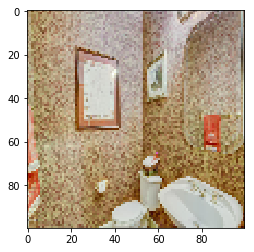

In [190]:
plt.imshow(X11[0])

In [191]:
text_array = np.zeros((535, 5))
for i, text in text_data.iterrows():
    text_array[i] = text.values

In [192]:
X2 = text_array[:, :4]
y = text_array[:, -1]

In [193]:
shuffle = np.arange(len(y))
np.random.shuffle(shuffle)

X11 = X11[shuffle]
X12 = X12[shuffle]
X13 = X13[shuffle]
X14 = X14[shuffle]
X2 = X2[shuffle]
y = y[shuffle]
y_log = np.log(y)

split_inedx = 450

x11_train = X11[:split_inedx]
x12_train = X12[:split_inedx]
x13_train = X13[:split_inedx]
x14_train = X14[:split_inedx]
x2_train = X2[:split_inedx]
y_train = y_log[:split_inedx]

x11_test = X11[split_inedx:]
x12_test = X12[split_inedx:]
x13_test = X13[split_inedx:]
x14_test = X14[split_inedx:]
x2_test = X2[split_inedx:]
y_test = y_log[split_inedx:]

x2_min = np.min(x2_train, axis=0)
x2_max = np.max(x2_train, axis=0)
x2_train = (x2_train - x2_min) / (x2_max - x2_min)
x2_test = (x2_test - x2_min) / (x2_max - x2_min)

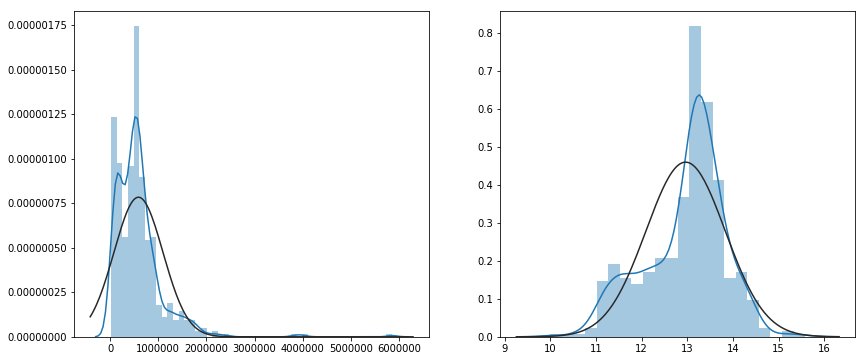

In [194]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
sns.distplot(y, fit=stats.norm)
plt.subplot(122)
sns.distplot(y_log, fit=stats.norm)

In [256]:
# cnn model
def visual_model(input_layer):
    conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu')(input_layer)
    bat1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bat1)
    conv2 = Conv2D(32, kernel_size=(3, 3), activation='relu')(pool1)
    bat2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(3, 3))(bat2)
    conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool2)
    bat3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bat3)
    flat = Flatten()(pool3)
    x = Dense(16)(flat)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.5)(x)
    
    x = Dense(4)(x)
    x = Activation("relu")(x)
    return x

In [257]:
# visual features (cnn)
visual_input1 = Input(shape=(row, col, 3), name='visual_input1')
visual1 = visual_model(visual_input1)

visual_input2 = Input(shape=(row, col, 3), name='visual_input2')
visual2 = visual_model(visual_input2)

visual_input3 = Input(shape=(row, col, 3), name='visual_input3')
visual3 = visual_model(visual_input3)

visual_input4 = Input(shape=(row, col, 3), name='visual_input4')
visual4 = visual_model(visual_input4)

# textual features (mlp)
textual_input = Input(shape=(4,), name='textual_input')

# merge visual and textual layers
x = keras.layers.concatenate([visual1, visual2, visual3, visual4, textual_input])

# fully connectied
x = Dense(32, activation='sigmoid')(x)
x = Dense(16, activation='sigmoid')(x)
# x = Dropout(0.2)(x)

# output
main_output = Dense(1, activation='linear', name='main_output')(x)

In [258]:
model = Model(inputs=[visual_input1, visual_input2, visual_input3, visual_input4, textual_input], outputs=main_output)
model.compile(optimizer=keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 200),
              loss={'main_output': 'mean_squared_error'}, metrics={'main_output': [coeff_determination]})

model.fit([x11_train, x12_train, x13_train, x14_train, x2_train], y_train,
          validation_split=0.3, 
          shuffle=True,
          epochs=500, 
          batch_size=32)

Train on 315 samples, validate on 135 samples
Epoch 1/500
315/315 [==============================] - 29s 91ms/step - loss: 137.0381 - coeff_determination: -189.4989 - val_loss: 131.8097 - val_coeff_determination: -256.9859
Epoch 2/500
315/315 [==============================] - 1s 3ms/step - loss: 128.6262 - coeff_determination: -180.3679 - val_loss: 123.1354 - val_coeff_determination: -239.7548
Epoch 3/500
315/315 [==============================] - 1s 3ms/step - loss: 120.2808 - coeff_determination: -178.3716 - val_loss: 114.6212 - val_coeff_determination: -223.0727
Epoch 4/500
315/315 [==============================] - 1s 3ms/step - loss: 112.0267 - coeff_determination: -162.7512 - val_loss: 106.4290 - val_coeff_determination: -207.0499
Epoch 5/500
315/315 [==============================] - 1s 3ms/step - loss: 104.3449 - coeff_determination: -139.2750 - val_loss: 98.8854 - val_coeff_determination: -192.3960
Epoch 6/500
315/315 [==============================] - 1s 3ms/step - loss: 97.

In [259]:
y_hat = model.predict([x11_test, x12_test, x13_test, x14_test, x2_test])

In [260]:
mean_squared_error(y[split_inedx:], np.e**y_hat), mean_absolute_error(y[split_inedx:], np.e**y_hat)

(198695453495.16266, 299611.57886029413)

In [263]:
np.sum(np.where(y>1000000, 1, 0))

60

In [251]:
for y1, y2 in zip(y[split_inedx:], (np.e**y_hat).ravel()):
    print("y: ",y1, ", y_hat: ", y2)

y:  710000.0 , y_hat:  638293.75
y:  254900.0 , y_hat:  397586.97
y:  740000.0 , y_hat:  491174.03
y:  995888.0 , y_hat:  367417.97
y:  625000.0 , y_hat:  567674.5
y:  349900.0 , y_hat:  576346.3
y:  1550000.0 , y_hat:  618377.06
y:  189000.0 , y_hat:  439468.78
y:  625000.0 , y_hat:  653307.7
y:  949000.0 , y_hat:  647353.75
y:  875000.0 , y_hat:  642679.4
y:  429900.0 , y_hat:  400502.44
y:  925000.0 , y_hat:  620393.1
y:  439900.0 , y_hat:  623546.94
y:  324999.0 , y_hat:  285523.34
y:  1045000.0 , y_hat:  513408.03
y:  949000.0 , y_hat:  502725.03
y:  479000.0 , y_hat:  570004.44
y:  1595000.0 , y_hat:  646236.06
y:  389000.0 , y_hat:  665277.5
y:  1495000.0 , y_hat:  658113.4
y:  160000.0 , y_hat:  115207.72
y:  825500.0 , y_hat:  638485.5
y:  572000.0 , y_hat:  591821.8
y:  59900.0 , y_hat:  90710.88
y:  1795000.0 , y_hat:  323201.72
y:  895000.0 , y_hat:  659875.56
y:  575000.0 , y_hat:  661040.2
y:  469900.0 , y_hat:  658596.8
y:  520000.0 , y_hat:  264637.7
y:  499000.0 , y_ha